Fitting classification model using auto-sklearn

In [1]:
!pip3 install auto-sklearn
!pip3 install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import OrderedDict

from sklearn import datasets
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

DISPLAY_PRECISION = 4
pd.set_option("display.precision", DISPLAY_PRECISION)

In [2]:
# https://automl.github.io/auto-sklearn/master/index.html
from pprint import pprint

import sklearn.datasets
import sklearn.metrics

import autosklearn.classification

In [10]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
type(data)
print(data)

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
 

In [16]:
print("The sklearn breast cancer dataset keys:")
print(data.keys()) # dict_keys(['target_names', 'target', 'feature_names', 'data', 'DESCR'])
print("---")

# Note that we need to reverse the original '0' and '1' mapping in order to end up with this mapping:
# Benign = 0 (negative class)
# Malignant = 1 (positive class)

li_classes = [data.target_names[1], data.target_names[0]]
li_target = [1 if x==0 else 0 for x in list(data.target)]
li_ftrs = list(data.feature_names)

print("There are 2 target classes:")
print("li_classes", li_classes)
print("---")
print("Target class distribution from a total of %d target values:" % len(li_target))
print(pd.Series(li_target).value_counts())
print("---")

df_all = pd.DataFrame(data.data[:,:], columns=li_ftrs)
print("Describe dataframe, first 6 columns:")
print(df_all.iloc[:,:6].describe().to_string())

The sklearn breast cancer dataset keys:
dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])
---
There are 2 target classes:
li_classes ['benign', 'malignant']
---
Target class distribution from a total of 569 target values:
0    357
1    212
dtype: int64
---
Describe dataframe, first 6 columns:
       mean radius  mean texture  mean perimeter    mean area  mean smoothness  mean compactness
count   569.000000    569.000000      569.000000   569.000000       569.000000        569.000000
mean     14.127292     19.289649       91.969033   654.889104         0.096360          0.104341
std       3.524049      4.301036       24.298981   351.914129         0.014064          0.052813
min       6.981000      9.710000       43.790000   143.500000         0.052630          0.019380
25%      11.700000     16.170000       75.170000   420.300000         0.086370          0.064920
50%      13.370000     18.840000       86.240000   551.100000         0.095870   

The tagged data set is from the "Breast Cancer Wisconsin (Diagnostic) Database" freely available in python's sklearn library, for details see:
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Number of Samples: 569
Number of Features: 30 numeric, predictive attributes
Number of Classes: 2
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Ten real-valued features are computed for each cell nucleus. The mean, standard error and 'worst' or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, the radius measurements are for the 'mean radius', 'standard error of the radius', and 'worst radius'. All feature values are recoded with four significant digits.

The two target classes correspond to negative outcomes (Benign) and positive outcomes (Malignant).

This original data set will be randomly split into two sets for train and test purposes.

Create a correlation heatmap of absolute correlation scores

In [20]:
TEST_SIZE_RATIO = 0.5  # split into 2 equally sized train and test sets

# Setup X and y
X = df_all
y = pd.Series(li_target)

X_train_0, X_test_0, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_RATIO, random_state=0)
print("X_train_0.shape, y_train.shape", X_train_0.shape, y_train.shape)
print("X_test_0.shape, y_test.shape", X_test_0.shape, y_test.shape)

X_train_0.shape, y_train.shape (284, 30) (284,)
X_test_0.shape, y_test.shape (285, 30) (285,)


Function correlation_matrix: X.shape, y.shape, yX.shape: (284, 30) (284,) (284, 31)



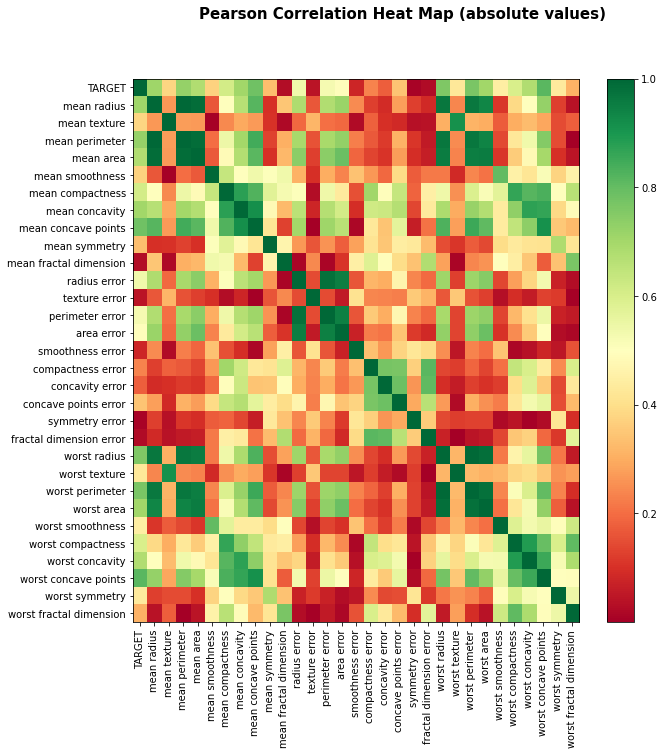

In [21]:
def correlation_matrix(y, X, is_plot=False):
  # Calculate and plot the correlation symmetrical matrix
  # Return:
  # yX - concatenated data
  # yX_corr - correlation matrix, pearson correlation of values from -1 to +1
  # yX_abs_corr - correlation matrix, absolute values
  
  yX = pd.concat([y, X], axis=1)
  yX = yX.rename(columns={0: 'TARGET'})  # rename first column

  print("Function correlation_matrix: X.shape, y.shape, yX.shape:", X.shape, y.shape, yX.shape)
  print()

  # Get feature correlations and transform to dataframe
  yX_corr = yX.corr(method='pearson')

  # Convert to abolute values
  yX_abs_corr = np.abs(yX_corr) 
  
  if is_plot:
    plt.figure(figsize=(10, 10))
    plt.imshow(yX_abs_corr, cmap='RdYlGn', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xticks(range(len(yX_abs_corr)), yX_abs_corr.columns, rotation='vertical')
    plt.yticks(range(len(yX_abs_corr)), yX_abs_corr.columns);
    plt.suptitle('Pearson Correlation Heat Map (absolute values)', fontsize=15, fontweight='bold')
    plt.show()
  
  return yX, yX_corr, yX_abs_corr

# Build the correlation matrix for the train data
yX, yX_corr, yX_abs_corr = correlation_matrix(y_train, X_train_0, is_plot=True)  

The code below is from the auto-sklearn example so the naming convention of the datasets and fields may be different from what was done earlier

In [24]:
X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = \
    sklearn.model_selection.train_test_split(X, y, random_state=1)


In [25]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_classification_example_tmp',
)
automl.fit(X_train, y_train, dataset_name='breast_cancer')


AutoSklearnClassifier(per_run_time_limit=30, time_left_for_this_task=120,
                      tmp_folder='/tmp/autosklearn_classification_example_tmp')

In [26]:
print(automl.leaderboard())

          rank  ensemble_weight                 type    cost  duration
model_id                                                              
7            1             0.08          extra_trees  0.0142    1.7704
16           2             0.02    gradient_boosting  0.0213    1.1929
2            3             0.02        random_forest  0.0284    1.9927
36           4             0.08  k_nearest_neighbors  0.0284    1.0155
26           5             0.04          extra_trees  0.0284    2.6830
13           6             0.02    gradient_boosting  0.0284    1.5754
22           7             0.08    gradient_boosting  0.0284    1.3222
3            8             0.12                  mlp  0.0284    1.2585
11           9             0.02        random_forest  0.0284    2.6738
8           10             0.04        random_forest  0.0355    2.2746
37          11             0.06    gradient_boosting  0.0355    1.7949
5           12             0.02        random_forest  0.0355    2.4364
9     

In [27]:
pprint(automl.show_models(), indent=4)

{   2: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f2e610e8e10>,
           'cost': 0.028368794326241176,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f2e5b16cf90>,
           'ensemble_weight': 0.02,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f2e610e8610>,
           'model_id': 2,
           'rank': 3,
           'sklearn_classifier': RandomForestClassifier(max_features=5, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)},
    3: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f2e600a0210>,
           'cost': 0.028368794326241176,
           'data_preprocessor': <autosklearn.pipeline.component

In [28]:
predictions = automl.predict(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_test, predictions))

Accuracy score: 0.951048951048951
